# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

In [1]:
# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gym.core import ObservationWrapper
from gym.spaces import Box

from scipy.misc import imresize
from torchvision.transforms import Resize
from torchvision.transforms.functional import *
import torch

### Let's play some old videogames
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/nerd.png)

This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [ ]:
!pip install atari-py

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f68abce17b8>, 'Connection to pypi.org timed out. (connect timeout=15)')': /simple/atari-py/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f68abce1780>, 'Connection to pypi.org timed out. (connect timeout=15)')': /simple/atari-py/


In [3]:
env.observation_space.shape

NameError: name 'env' is not defined

/home/dmitriy/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


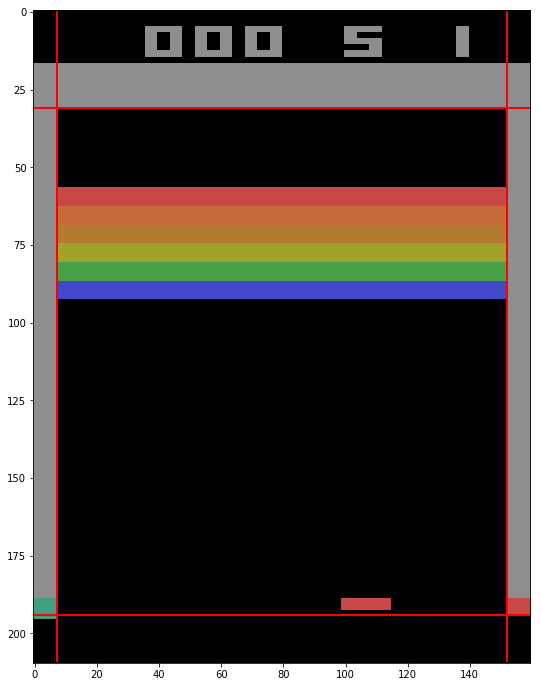

In [4]:
env = gym.make("BreakoutDeterministic-v0") 
s=env.reset()
w = env.observation_space.shape[1]
h = env.observation_space.shape[0]
plt.figure(figsize=(20,12))
plt.imshow(s, interpolation='none', cmap='gray')
cutframe = (7,152,31,194)
plt.plot([cutframe[0]]*h ,range(h) ,color='red', lw=2)
plt.plot([cutframe[1]]*h ,range(h) ,color='red', lw=2)
plt.plot( range(w),[cutframe[2]]*w ,color='red', lw=2)
plt.plot(range(w),[cutframe[3]]*w ,color='red', lw=2)

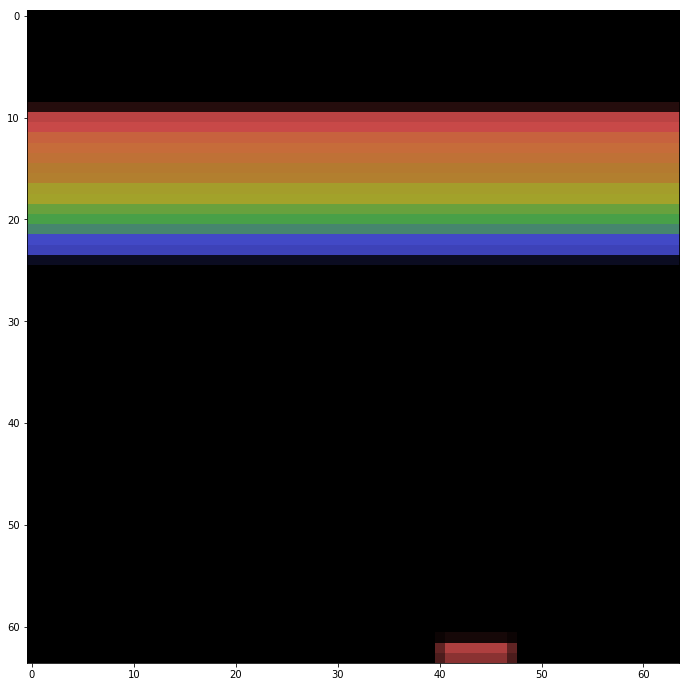

In [5]:
plt.figure(figsize=(20,12))
plt.imshow(resize(crop(to_pil_image(s),32,8,194-32,152-8),size=(64,64)))

In [5]:


class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1,64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type

        img = crop(to_pil_image(img),32,8,194-32,152-8)
        img = resize(img,self.img_size[1:])
        img = to_grayscale(img)

        
        
        return to_tensor(img).numpy()

In [7]:
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(1, 64, 64)
0.0    0.5803922
Formal tests seem fine. Here's an example of what you'll get.


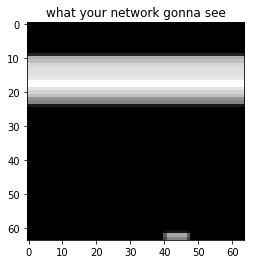

In [6]:
import gym
# spawn game instance for tests
env = gym.make("BreakoutDeterministic-v0")  # create raw env
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

print(observation_shape)

env.reset()
obs, _, _, _ = env.step(env.action_space.sample())
print(np.min(obs),'  ', np.max(obs))

# test observation
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to (0,1) range"

print("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs[0, :, :], interpolation='none', cmap='gray')

### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to fing optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [7]:
from framebuffer import FrameBuffer


def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env


env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


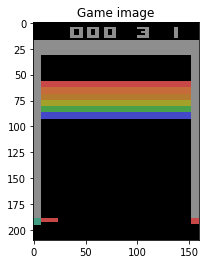

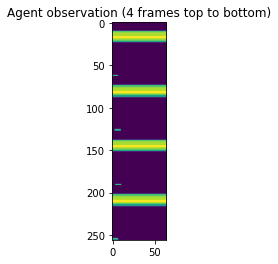

In [6]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_dim[2]]))

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        """A simple DQN agent"""
        nn.Module.__init__(self)
        self.epsilon = epsilon
        self.n_actions = n_actions
        img_c, img_w, img_h = state_shape

        # Define your network body here. Please make sure agent is fully contained here
        
        self.conv1 = nn.Conv2d(4,16,3,stride=2)
        self.conv2 = nn.Conv2d(16,32,3,stride=2)
        self.conv3 = nn.Conv2d(32,64,3,stride=2)
        self.lin1 = nn.Linear(64*7*7,256)
        self.lin2 = nn.Linear(256,self.n_actions)
        

    def forward(self, state_t):
        """
        takes agent's observation (Variable), returns qvalues (Variable)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        Hint: if you're running on GPU, use state_t.cuda() right here.
        """

        # Use your network to compute qvalues for given state
        x = F.relu(self.conv1(state_t))
        #print(f'conv1 {x.shape}')
        x = F.relu(self.conv2(x))
        #print(f'conv2 {x.shape}')
        x = F.relu(self.conv3(x))
        #print(f'conv3 {x.shape}')
        x = F.relu(self.lin1(x.view(x.shape[0],-1)))
        
        qvalues = self.lin2(x)
        #print(f'qval {qvalues.shape} need  {state_t.shape[0]} \ {n_actions}')
        assert isinstance(
            qvalues, Variable) and qvalues.requires_grad, "qvalues must be a torch variable with grad"
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not Variables
        """
        states = Variable(torch.FloatTensor(np.asarray(states)))
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [10]:
agent = DQNAgent(state_dim, n_actions, epsilon=0.5)

Now let's try out our agent to see if it raises any errors.

In [11]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(
                axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [79]:
agent.conv1

Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2))

In [12]:
evaluate(env, agent, n_games=10)

6.7

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here __to get 2 bonus points__.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [13]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [14]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time
    """
    # initial state
    #s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    
    s = env.reset()
    reward = 0
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        s_next, r, done, info = env.step(action)
        reward += r
        
        exp_replay.add(s,action,r,s_next,done)
        
        if done:
            env.reset()

            

    return reward

In [15]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (
        10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [
        0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"

print("Well done!")

Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)



In [16]:
target_network = DQNAgent(state_dim, n_actions)

In [17]:
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.
__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [29]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = Variable(torch.FloatTensor(
        states))    # shape: [batch_size, c, h, w]
    actions = Variable(torch.LongTensor(actions))    # shape: [batch_size]
    rewards = Variable(torch.FloatTensor(rewards))  # shape: [batch_size]
    # shape: [batch_size, c, h, w]
    next_states = Variable(torch.FloatTensor(next_states))
    is_done = Variable(torch.FloatTensor(
        is_done.astype('float32')))  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues,1)[0]
    #print(next_state_values)

    assert next_state_values.dim(
    ) == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma*next_state_values*is_not_done

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2,0, keepdim=True)
    #print(loss)
    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

In [53]:
# sanity checks
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, gamma=0.99,
                       check_shapes=True)
print(loss)
loss.backward()

assert isinstance(loss, Variable) and tuple(loss.data.size()) == (
    1,), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.numpy() !=
              0), "loss must be differentiable w.r.t. network weights"

tensor([0.0014], grad_fn=<MeanBackward0>)


In [54]:
tuple(loss.data.size())

(1,)

In [85]:
torch.tensor([1]).shape

torch.Size([1])

### Main loop

It's time to put everything together and see if it learns anything.

In [55]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [56]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000)

242.0

In [32]:
s=[]
s.append(loss.data.cpu().numpy())
a=loss.data.cpu().numpy()

In [37]:
float(a)

0.003752267686650157

In [57]:
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)
agent.epsilon = 0.99

buffer size = 100000, epsilon = 0.31481


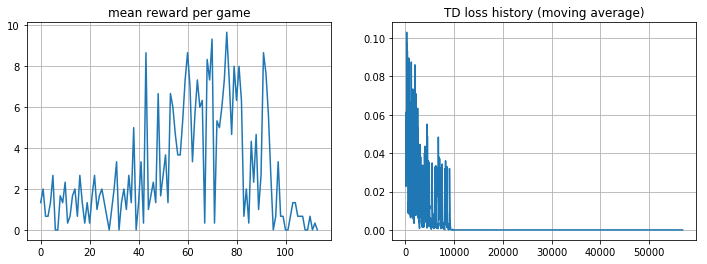

 57%|█████▋    | 56954/100000 [1:04:13<34:13, 20.96it/s]  

KeyboardInterrupt: 

In [58]:
for i in trange(10**5):

    # play
    play_and_record(agent, env, exp_replay, 10)

    # train
    states, actions, rewards, next_states, is_done = exp_replay.sample(10)

    loss = compute_td_loss(states, actions, rewards, next_states, is_done)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    td_loss_history.append(loss.data.cpu().numpy()[0])

    # adjust agent parameters
    if i % 500 == 0:
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))

        # Load agent weights into target_network
        target_network = DQNAgent(state_dim, n_actions)
        target_network.load_state_dict(agent.state_dict())

    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))
        plt.figure(figsize=[12, 4])
        plt.subplot(1, 2, 1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(
            np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

In [59]:
assert np.mean(mean_rw_history[-10:]) > 10.
print("That's good enough for tutorial.")

AssertionError: 

 57%|█████▋    | 56954/100000 [1:04:30<34:13, 20.96it/s]

__ How to interpret plots: __


This aint no supervised learning so don't expect anything to improve monotonously. 
* __ TD loss __ is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* __ mean reward__ is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes 5-10k steps to "warm up" agent before it starts to get better.
* __ buffer size__ - this one is simple. It should go up and cap at max size.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - __ it means you need to increase epsilon__. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Also please ignore first 100-200 steps of each plot - they're just oscillations because of the way moving average works.

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

__Training will take time.__ A lot of it actually. An optimistic estimate is to say it's gonna start winning (average reward > 10) after 20k steps. 

But hey, long training time isn't _that_ bad:
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/training.png)


### Video

In [ ]:
# Don't forget to reset epsilon back to previous value if you want to go on training
agent.epsilon = 0

In [ ]:
# record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(), directory="videos", force=True)
sessions = [evaluate(env_monitor, agent, n_games=1) for _ in range(100)]
env_monitor.close()

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

## Assignment part I (5 pts)

We'll start by implementing target network to stabilize training.

To do that you should use TensorFlow functionality. 

We recommend thoroughly debugging your code on simple tests before applying it in atari dqn.

## Bonus I (2+ pts)

Implement and train double q-learning.

This task contains of
* Implementing __double q-learning__ or __dueling q-learning__ or both (see tips below)
* Training a network till convergence
  * Full points will be awarded if your network gets average score of >=10 (see "evaluating results")
  * Higher score = more points as usual
  * If you're running out of time, it's okay to submit a solution that hasn't converged yet and updating it when it converges. _Lateness penalty will not increase for second submission_, so submitting first one in time gets you no penalty.


#### Tips:
* Implementing __double q-learning__ shouldn't be a problem if you've already have target networks in place.
  * You will probably need `tf.argmax` to select best actions
  * Here's an original [article](https://arxiv.org/abs/1509.06461)

* __Dueling__ architecture is also quite straightforward if you have standard DQN.
  * You will need to change network architecture, namely the q-values layer
  * It must now contain two heads: V(s) and A(s,a), both dense layers
  * You should then add them up via elemwise sum layer.
  * Here's an [article](https://arxiv.org/pdf/1511.06581.pdf)

## Bonus II (5+ pts): Prioritized experience replay

In this section, you're invited to implement prioritized experience replay

* You will probably need to provide a custom data structure
* Once pool.update is called, collect the pool.experience_replay.observations, actions, rewards and is_alive and store them in your data structure
* You can now sample such transitions in proportion to the error (see [article](https://arxiv.org/abs/1511.05952)) for training.

It's probably more convenient to explicitly declare inputs for "sample observations", "sample actions" and so on to plug them into q-learning.

Prioritized (and even normal) experience replay should greatly reduce amount of game sessions you need to play in order to achieve good performance. 

While it's effect on runtime is limited for atari, more complicated envs (further in the course) will certainly benefit for it.

Prioritized experience replay only supports off-policy algorithms, so pls enforce `n_steps=1` in your q-learning reference computation (default is 10).